In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

In [2]:
# Set paths to data and results used through the document:
sp_data_folder = '/home/chutianhao/R/Projects/snRNA_scRNA_hcc/project/Spatial/raw_data'
results_folder = '/home/chutianhao/cell2loc/results/snRNA_scRNA_hcc'
sample_name = ["HCC", "PT1", "PT4", "RT2", "TI1", "TI3"]

In [3]:
def read_and_qc(sample_name, path=sp_data_folder + '/'):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    import re
    adata.X = adata.X.toarray()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.X = csr_matrix(adata.X)
    pattern = re.compile("^mt-", flags=re.IGNORECASE) # for human and mice
    adata.var['mt'] = adata.var["SYMBOL"].str.contains(pattern)
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [4]:
# Read the data into anndata objects
slides = []
for i in sample_name:
    slides.append(read_and_qc(i))

# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_name,
    index_unique=None
)          

/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1820

In [5]:
# use this if using new anndata
adata = slides[2]

In [6]:
# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
adata = adata[:, ~adata.var['mt'].values]

/tmp/ipykernel_840/2491976396.py:47: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}


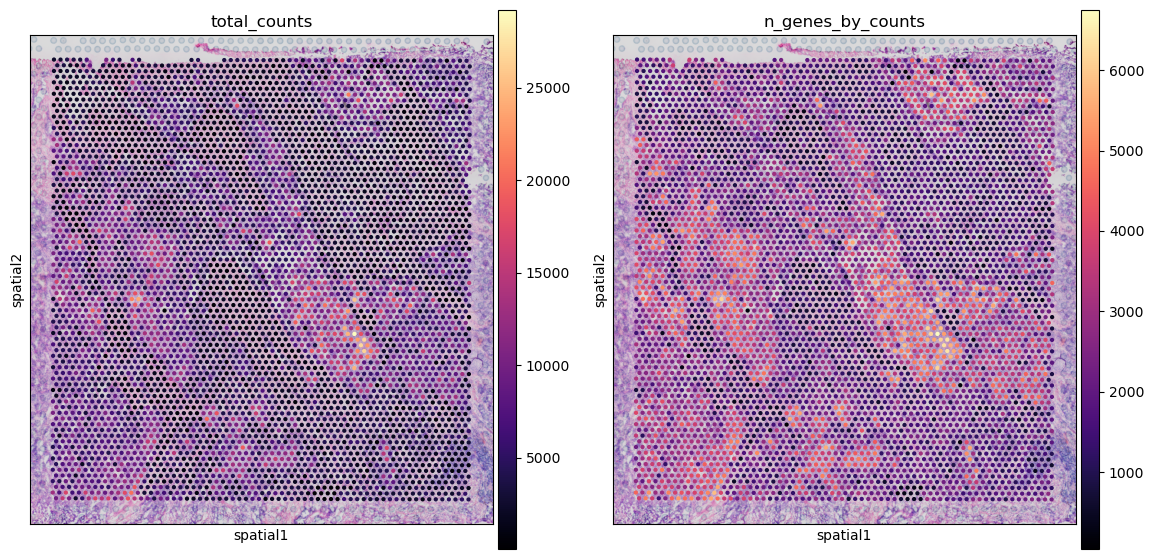

In [7]:
# plot QC values over slide images using scanpy functions
slide = select_slide(adata, 'PT4')

with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'white'}):
    sc.pl.spatial(slide, img_key = "hires", cmap='magma',
                  library_id=list(slide.uns['spatial'].keys())[0],
                  color=['total_counts', 'n_genes_by_counts'], size=1,
                  gene_symbols='SYMBOL', show=False, return_fig=True)

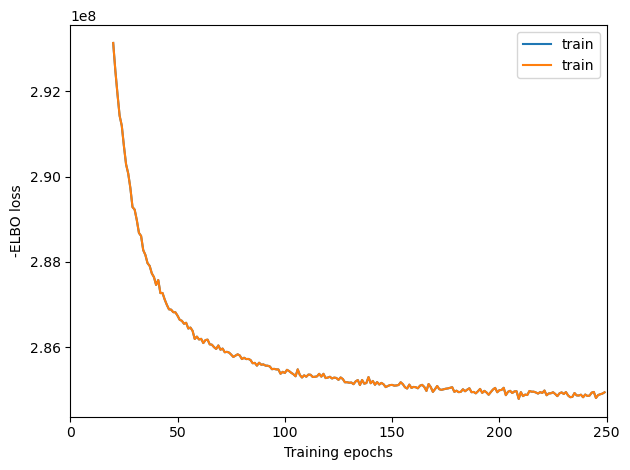

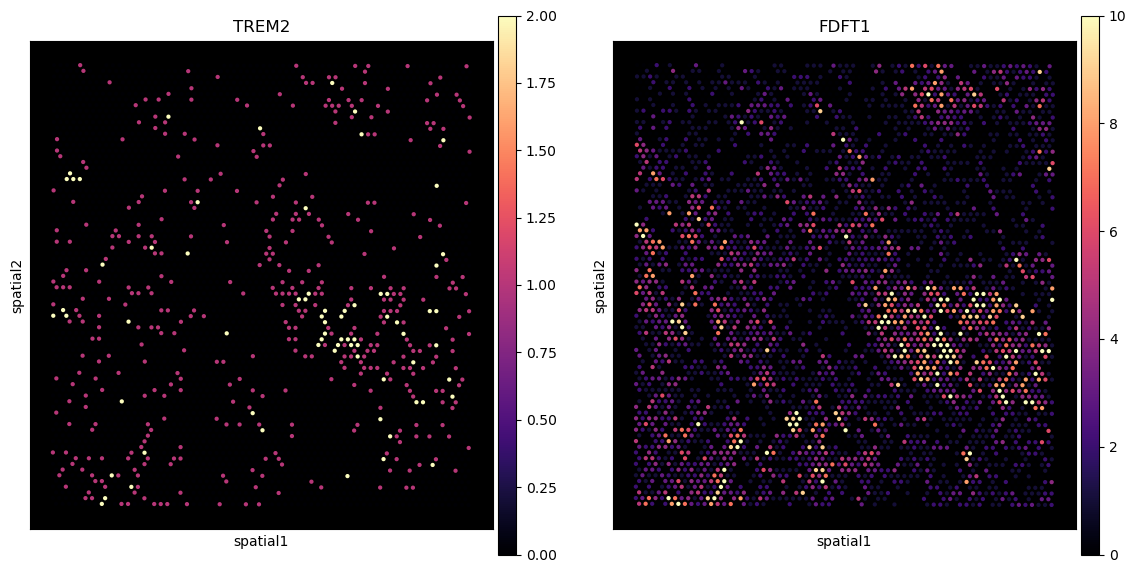

In [28]:
# plot the expression of individual genes without tissue images
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(slide,
                  color=["TREM2", "FDFT1"], img_key=None, size=1,
                  vmin=0, cmap='magma', vmax='p99.0',
                  gene_symbols='SYMBOL'
                 )

In [8]:
# select a slide and add count matrix to .raw
adata_vis = adata.copy()
adata_vis.raw = adata_vis

In [15]:
# load the sc/snRNAseq reference data (raw counts)
adata_ref = sc.read_h5ad("/home/chutianhao/cell2loc/sc_data/scRNA_snRNA_hcc/adata_sc_ref_high_res.h5ad")

In [16]:
adata_ref.obs.celltype.cat.categories

Index(['Activated CD4+ T', 'Arterial EC', 'B cell', 'CCR6+ CD8+ T',
       'CCR7+ CD4+ T', 'CD4+ Tcm', 'CD16+ NK', 'Capillary EC',
       'Classical monocyte', 'Cycling cell', 'Effector CD8+ T',
       'Endothelial cell', 'FOLR2+ TAM', 'Hepatocytes', 'IFN-TAM',
       'Inflam-TAM', 'Kupffer cell', 'NKT', 'Nonclassical monocyte',
       'Plasma cell', 'Proliferating EC', 'TNFRSF9+ CD8+ T', 'TREM2+ LAM',
       'Tip-like EC', 'Treg', 'Venous EC', 'XCL1+ NK', 'apCAF', 'cDC1', 'cDC2',
       'cDC3', 'lpCAF', 'mCAF', 'vCAF'],
      dtype='object')

In [12]:
import re

In [20]:
def map_fn(x): 
    if re.match("CD4", x):
        return "T cells"
    elif re.match("CD8", x):
        return "T cells"
    elif re.match("Treg", x):
        return "T cells"
    elif re.match("CXCL13", x):
        return "T cells"
    elif re.search("monocyte", x):
        return "mono/macrophage"
    elif re.search("[TL]AM", x): 
        return "mono/macrophage"
    elif re.search("NK", x):
        return "NK cells"
    elif re.match("T naive", x): 
        return "T cells"
    elif re.match("Kupffer cell", x):
        return "mono/macrophage"
    elif re.match("cDC", x):
        return "mono/macrophage"
    else:
        return x

In [13]:
def map_fn(x):
    if re.match("archtype", x):
        return "Hepatocytes"
    elif re.match("inflammatory", x):
        return "Hepatocytes"
    elif re.match("Proliferation", x):
        return "Hepatocytes"
    else:
        return x

In [14]:
map_fn("archtype1")

'Hepatocytes'

In [20]:
adata_ref.obs["celltype"] = adata_ref.obs["new_celltype"].map(map_fn)

In [19]:
# subset anndata to selected condition
adata_ref.obs["condition"].unique()

['PT', 'RT']
Categories (2, object): ['PT', 'RT']

In [18]:
adata_ref = adata_ref[~adata_ref.obs["condition"].isin(["PNT", "adjancant normal"])]

In [20]:
adata_ref.obs.patient_id.value_counts()

patient_id
scPT2    10804
scPT5     7838
scPT3     5842
scRT3     5384
scPT4     5298
scRT1     4665
scPT1     4591
scRT2     2528
Name: count, dtype: int64

Genes selection with cell2location methods

/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/cell2location/utils/filtering.py:26: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = np.array((adata.X > 0).sum(0)).flatten()
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


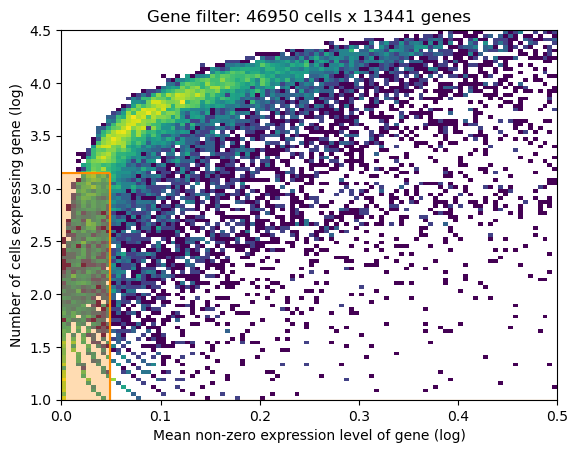

In [21]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [22]:
adata_ref.obs

,patient_id,condition,sampletype,nCount_RNA,nFeature_RNA,mt_ratio,ribo_ratio,S.Score,G2M.Score,Phase,celltype,stress_ratio,batch
PT1_TACCTGCGTGCGGCTT,scPT1,PT,scRNA-seq,214298.0,9204,7.381129,18.796169,-0.053840,-0.102457,G1,Hepatocytes,0.439575,0
PT1_TGGTTAGGTGCTCTCT,scPT1,PT,scRNA-seq,163640.0,8026,1.615197,16.724967,-0.059459,-0.094151,G1,Hepatocytes,0.461990,0
PT1_AGGTAGGAGACCAACG,scPT1,PT,scRNA-seq,155243.0,8678,5.890871,7.488085,-0.081496,0.954104,G2M,Hepatocytes,0.535290,0
PT1_GAACGTTAGGGATCGT,scPT1,PT,scRNA-seq,149313.0,7996,8.163050,13.251132,-0.007306,0.441963,G2M,Hepatocytes,0.484887,0
PT1_TCATACTGTTTCAGAC,scPT1,PT,scRNA-seq,131064.0,7970,8.769534,10.258362,-0.026158,-0.072507,G1,Hepatocytes,0.466184,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RT3_AAGCATCGTTGGTGTT,scRT3,RT,scRNA-seq,762.0,454,5.376344,20.000000,-0.050423,-0.083066,G1,CD4+ Tcm,5.380577,0
RT3_TCCATGCAGCGTTCAT,scRT3,RT,scRNA-seq,840.0,615,1.298701,9.848485,0.038843,0.751212,G2M,XCL1+ NK,6.071429,0
RT3_GGTCACGAGCTGACCC,scRT3,RT,scRNA-seq,543.0,411,5.306122,0.136054,0.005745,-0.016462,S,Endothelial cell,3.867403,0
RT3_CCTAACCTCATAGACC,scRT3,RT,scRNA-seq,542.0,424,1.466667,0.800000,0.008864,-0.082701,S,Endothelial cell,8.671587,0


In [23]:
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='patient_id',
                        # cell type, covariate used for constructing signatures
                        labels_key='celltype',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=["patient_id"]
                       )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [24]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'patient_id',
│   'labels_key': 'celltype',
│   'categorical_covariate_keys': ['patient_id'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   8   │
│         n_cells          │ 46950 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  34   │
│          n_vars          │ 13441 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient_id'] │   scPT1    │          0          │
│                         │   scPT2    │          1          │
│                         │   scPT3    │          2          │
│                         │   scPT4    │          3          │
│                         │   scPT5    │          4          │
│                         │   scRT1    │          5          │
│                         │   scRT2    │          6          │
│                         │   scRT3    │          7          │
└─────────────────────────┴────────────┴─────────────────────┘

                         labels State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃      Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │   Activated CD4+ T    │          0          │
│                       │      Arterial EC      │          1          │
│                       │        B cell         │          2          │
│                       │     CCR6+ CD8+ T      │          3          │
│                       │     CCR7+ CD4+ T      │          4          │
│                       │       CD4+ Tcm        │          5          │
│                       │       CD16+ NK        │          6          │
│                       │     Capillary EC      │          7          │
│                       │  Classical monocyte   │          8          │
│                       │     Cycling cell      │          9          │
│                       │    Effector CD8+ T    │         10          │
│                       │   Endothelial cell    │         11          │
│                       │      FOLR2+ TAM       │         12          │
│                       │      Hepatocytes      │         13          │
│                       │        IFN-TAM        │         14          │
│                       │      Inflam-TAM       │         15          │
│                       │     Kupffer cell      │         16          │
│                       │          NKT          │         17          │
│                       │ Nonclassical monocyte │         18          │
│                       │      Plasma cell      │         19          │
│                       │   Proliferating EC    │         20          │
│                       │    TNFRSF9+ CD8+ T    │         21          │
│                       │      TREM2+ LAM       │         22          │
│                       │      Tip-like EC      │         23          │
│                       │         Treg          │         24          │
│                       │       Venous EC       │         25          │
│                       │       XCL1+ NK        │         26          │
│                       │         apCAF         │         27          │
│                       │         cDC1          │         28          │
│                       │         cDC2          │         29          │
│                       │         cDC3          │         30          │
│                       │         lpCAF         │         31          │
│                       │         mCAF          │         32          │
│                       │         vCAF          │         33          │
└───────────────────────┴───────────────────────┴─────────────────────┘

            extra_categorical_covs State Registry             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient_id'] │   scPT1    │          0          │
│                         │   scPT2    │          1          │
│                         │   scPT3    │          2          │
│                         │   scPT4    │          3          │
│                         │   scPT5    │          4          │
│                         │   scRT1    │          5          │
│                         │   scRT2    │          6          │
│                         │   scRT3    │          7          │
│                         │            │                     │
└─────────────────────────┴────────────┴─────────────────────┘

In [25]:
mod.train(max_epochs=250)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX A4500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of th

Epoch 250/250: 100%|██████████| 250/250 [13:26<00:00,  3.26s/it, v_num=1, elbo_train=2.85e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [13:26<00:00,  3.23s/it, v_num=1, elbo_train=2.85e+8]


In [27]:
# check if the training is converged
mod.plot_history(20)

In [29]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:14<00:00, 69.97it/s]


In [30]:
# check the summary of poesterior distribution
adata_ref.uns['mod'].keys()

dict_keys(['model_name', 'date', 'factor_filter', 'factor_names', 'var_names', 'obs_names', 'post_sample_means', 'post_sample_stds', 'post_sample_q05', 'post_sample_q95'])

In [31]:
# Save model
mod.save(f"{results_folder}/model/sc_reference_signatures", overwrite=True)

# Save anndata object with results
adata_file = f"{results_folder}/model/sc_reference_signatures/adata_scref.h5ad"
adata_ref.write(adata_file)
adata_file

'/home/chutianhao/cell2loc/results/snRNA_scRNA_hcc/model/sc_reference_signatures/adata_scref.h5ad'

In [9]:
# load model and anndata object with results
adata_file = f"{results_folder}/model/sc_reference_signatures/adata_scref.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{results_folder}/model/sc_reference_signatures", adata_ref)

INFO     File /home/chutianhao/cell2loc/results/snRNA_scRNA_hcc/model/sc_reference_signatures/model.pt already     
         downloaded                                                                                                


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX A4500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: T

Epoch 1/426:   0%|          | 1/426 [00:00<04:36,  1.53it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/426:   0%|          | 1/426 [00:00<04:44,  1.49it/s, v_num=1]


In [10]:
adata_ref = mod.export_posterior(
    adata_ref, use_quantiles=True,
    sample_kwargs={'batch_size': 2500}
)

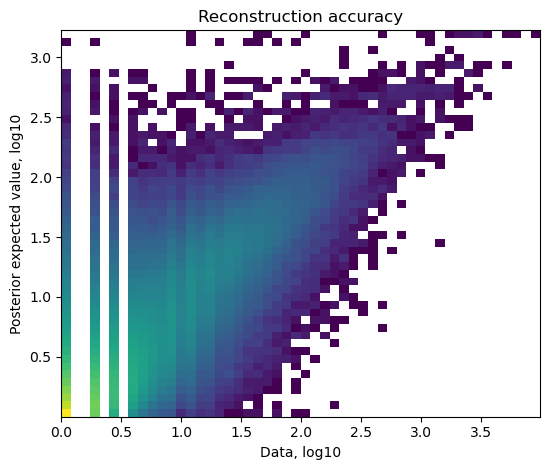

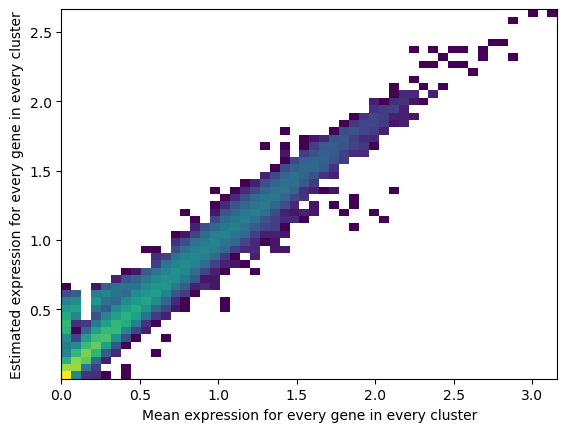

In [11]:
mod.plot_QC(summary_name="q95")

In [12]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Activated CD4+ T,Arterial EC,B cell,CCR6+ CD8+ T,CCR7+ CD4+ T
SAMD11,0.000493,0.002823,0.002061,0.001963,0.000620
NOC2L,0.052853,0.258557,0.118705,0.092795,0.106584
HES4,0.067137,3.183662,0.106412,0.127295,0.138090
ISG15,0.946175,2.412075,0.669764,1.304642,1.375834
AGRN,0.000482,0.680648,0.005061,0.000704,0.000389


In [13]:
# set index to SYMBOL in adata_vis
adata_vis.var["ENSEMBL"] = adata_vis.var_names.copy()
adata_vis.var_names = adata_vis.var["SYMBOL"].astype("object")
adata_vis.var_names_make_unique()
adata_vis.var.drop(columns='ENSEMBL', inplace=True)

In [53]:
# before setup anndata, make sure the adata.X contains counts rather than normalized counts
adata_vis.X = adata_vis.layers["counts"].copy()

KeyError: 'counts'

In [14]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [15]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=10,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4977  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 13428 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    PT4     │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [16]:
mod.train(max_epochs=15000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the

Epoch 15000/15000: 100%|██████████| 15000/15000 [37:55<00:00,  6.52it/s, v_num=1, elbo_train=2.9e+7]

`Trainer.fit` stopped: `max_epochs=15000` reached.


Epoch 15000/15000: 100%|██████████| 15000/15000 [37:55<00:00,  6.59it/s, v_num=1, elbo_train=2.9e+7]


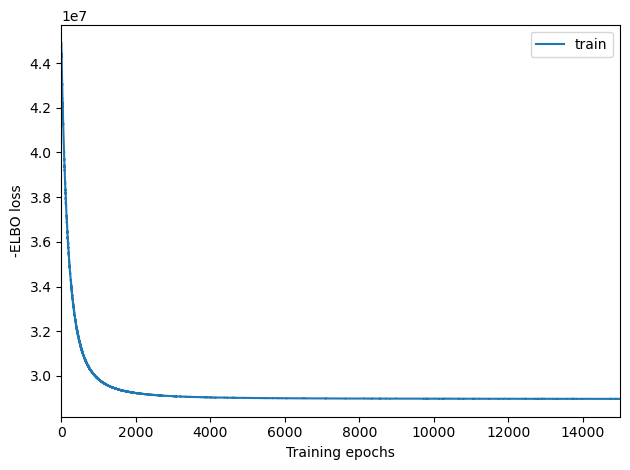

In [17]:
fig, ax = plt.subplots()
mod.plot_history(ax=ax)
fig

In [18]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

# Save model
mod.save(f"{results_folder}/model/sp_PT4_sc_new", overwrite=True)

# Save anndata object with results
adata_file = f"{results_folder}/model/sp_PT4_sc_new/sp_scref.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:26<00:00, 38.08it/s]


'/home/chutianhao/cell2loc/results/snRNA_scRNA_hcc/model/sp_PT4_sc_new/sp_scref.h5ad'

In [33]:
# load adata_vis and mod
adata_file = f"{results_folder}/model/sp_PT4_sn/sp_snref.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{results_folder}/model/sp_PT4_sn", adata_vis)

INFO     File /home/chutianhao/cell2loc/results/snRNA_scRNA_hcc/model/sp_PT4_sn/model.pt already downloaded        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the

Epoch 1/30000:   0%|          | 1/30000 [00:00<1:50:34,  4.52it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:00<1:52:57,  4.43it/s, v_num=1]


In [34]:
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:25<00:00, 38.95it/s]


In [35]:
mod.plot_QC(summary_name="q05")

In [29]:
adata_vis

AnnData object with n_obs × n_vars = 4977 × 12797
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'mt', 'n_cells_by_counts-HCC', 'mean_counts-HCC', 'log1p_mean_counts-HCC', 'pct_dropout_by_counts-HCC', 'total_counts-HCC', 'log1p_total_counts-HCC', 'n_cells_by_counts-PT1', 'mean_counts-PT1', 'log1p_mean_counts-PT1', 'pct_dropout_by_counts-PT1', 'total_counts-PT1', 'log1p_total_counts-PT1', 'n_cells_by_counts-PT4', 'mean_counts-PT4', 'log1p_mean_counts-PT4', 'pct_dropout_by_counts-PT4', 'total_counts-PT4', 'log1p_total_counts-PT4', 'n_cells_by_counts-RT2', 'mean_counts-RT2', 'log1p_mean_counts-RT2', 'pct_dropout_by_counts-RT2', 'total_counts-RT2', 'log1p_total_counts-RT2', 'n_cells_by_

In [36]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
slide2 = select_slide(adata_vis, 'PT4')

/tmp/ipykernel_840/2491976396.py:47: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}


In [37]:
adata_vis.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac',
       '_indices', '_scvi_batch', '_scvi_labels', 'B cells', 'CAF',
       'Endothelial cells', 'Myeloid cells', 'NK cells', 'Plasma cells',
       'Proliferation', 'T cells', 'archtype1', 'archtype2', 'inflammatory'],
      dtype='object')

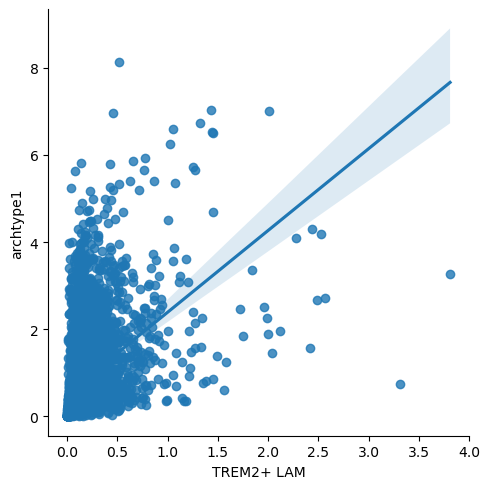

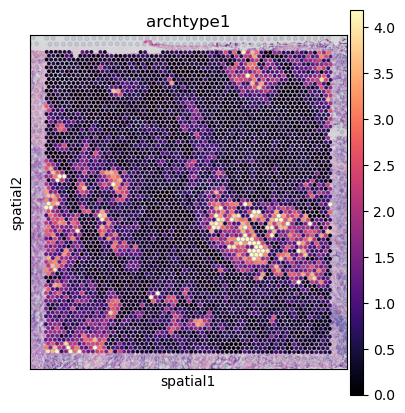

In [63]:
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide2, cmap='magma',
                  # show first 8 cell types
                  color=["archtype1"],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.0',
                 )

In [25]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ["CD4+ activated", "TREM2+ LAM", "CD8+ Tem"]
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'PT4')

/tmp/ipykernel_739/2491976396.py:47: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}


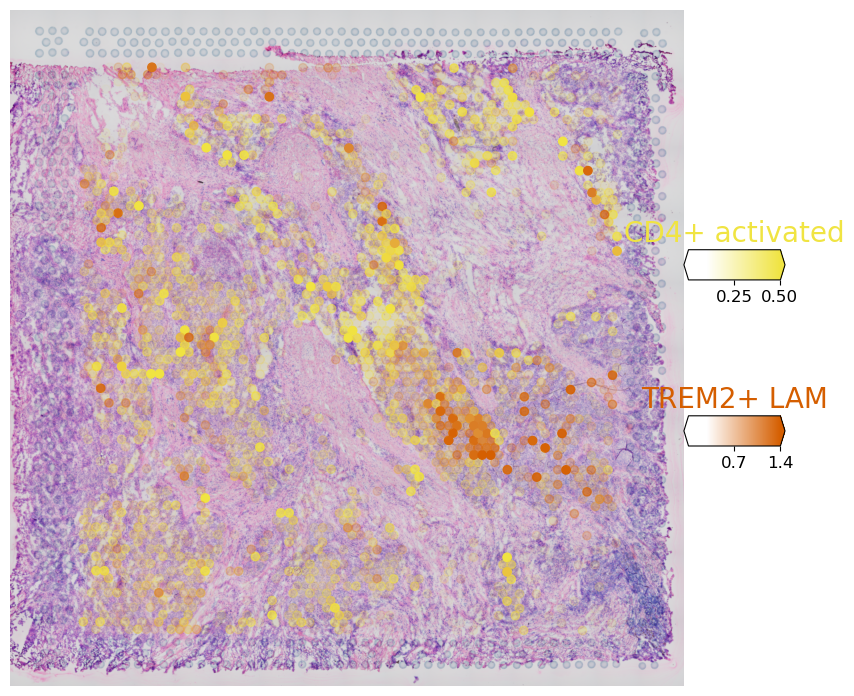

In [99]:
with mpl.rc_context({'figure.figsize': (10, 10)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.995,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )
    fig.savefig("PT4_cd4_TREM2.pdf")

In [40]:
slide2

AnnData object with n_obs × n_vars = 4977 × 14202
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', '_indices', '_scvi_batch', '_scvi_labels', 'B cells', 'CAF', 'Endothelial cells', 'Myeloid cells', 'NK cells', 'Plasma cells', 'Proliferation', 'T cells', 'archtype1', 'archtype2', 'inflammatory'
    var: 'feature_types', 'genome', 'mt', 'n_cells_by_counts-HCC', 'mean_counts-HCC', 'log1p_mean_counts-HCC', 'pct_dropout_by_counts-HCC', 'total_counts-HCC', 'log1p_total_counts-HCC', 'n_cells_by_counts-PT1', 'mean_counts-PT1', 'log1p_mean_counts-PT1', 'pct_dropout_by_counts-PT1', 'total_counts-PT1', 'log1p_total_counts-PT1', 'n_cells_by_counts-PT4', 'mean_counts-PT4', 'log1p_mean_counts-PT4', 'pct_dropout_by_counts-PT4', 'total_counts-PT4', 'log1p_total_counts-PT4', 'n

In [41]:
slide

AnnData object with n_obs × n_vars = 4977 × 12797
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', '_indices', '_scvi_batch', '_scvi_labels', 'B cells', 'CAF', 'CD4+ Tcm', 'CD4+ activated', 'CD8+ Tem', 'CD8+ Temra', 'CD8+ Tex', 'CD8+ Trm', 'CD8+ activated', 'CXCL13+ CD4+ T', 'Classical monocyte', 'Endothelial cells', 'FCGR3A+ NK', 'FOLR2+ TAM', 'Hepatocytes', 'IFN-TAM', 'Inflam-TAM', 'Kupffer cell', 'Neutrophils', 'Nonclassical monocyte', 'Plasma cells', 'T naive', 'TREM2+ LAM', 'Treg', 'XCL1+ NK', 'cDC1', 'cDC2', 'cDC3'
    var: 'feature_types', 'genome', 'mt', 'n_cells_by_counts-HCC', 'mean_counts-HCC', 'log1p_mean_counts-HCC', 'pct_dropout_by_counts-HCC', 'total_counts-HCC', 'log1p_total_counts-HCC', 'n_cells_by_counts-PT1', 'mean_counts-PT1', 'log1p_mean_co

In [42]:
cor_matrix = slide.obs.loc[:, ['B cells', 'CAF', 'CD4+ Tcm', 'CD4+ activated', 'CD8+ Tem', 'CD8+ Temra', 'CD8+ Tex', 'CD8+ Trm', 'CD8+ activated', 'CXCL13+ CD4+ T', 'Classical monocyte', 'Endothelial cells', 'FCGR3A+ NK', 'FOLR2+ TAM', 'Hepatocytes', 'IFN-TAM', 'Inflam-TAM', 'Kupffer cell', 'Neutrophils', 'Nonclassical monocyte', 'Plasma cells', 'T naive', 'TREM2+ LAM', 'Treg', 'XCL1+ NK', 'cDC1', 'cDC2', 'cDC3']]

In [45]:
cor_matrix = pd.concat([cor_matrix, slide2.obs.loc[:, ['archtype1', 'archtype2', 'inflammatory']]], axis="columns")

In [48]:
cor_matrix.drop(["Hepatocytes"], axis=1, inplace=True)

In [60]:
cor_mat = cor_matrix.corr(method="spearman")

In [52]:
import seaborn as sns

In [57]:
sns.heatmap(cor_mat, )

<Axes: >

In [61]:
cor_mat.to_csv("cor_mat.csv")

In [62]:
sns.lmplot(cor_matrix, x = "TREM2+ LAM", y = "archtype1",  )